In [20]:
from pathlib import Path
from tqdm import tqdm
import datetime as dt

import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow import keras
from tensorflow.keras.layers import Input, Dense, Lambda
from tensorflow.keras.models import Model

from HMC import HMC
from flux_preprocessing import load_dataset
from flux_utlis import fluxes_SIF_predict_noSIF

%matplotlib inline
plt.rcParams["legend.frameon"] = False
plt.rcParams['savefig.dpi'] = 310
plt.rcParams['font.size'] = 13
data_dir = Path("../data")

In [2]:
train, test, EV1_train1, EV2_train1, NEE_train1, label_train, EV1_test1, EV2_test1, NEE_test, label_test, NEE_max_abs = load_dataset(
    'NNinput_SCOPE_US_Ha1_1314.csv')

2022-03-24 22:53:28.130481: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-03-24 22:53:28.401992: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 3715 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1660 Ti, pci bus id: 0000:2b:00.0, compute capability: 7.5


In [3]:
def NN_noSIF(n_neuron, activation1, activation2):
    # GPP
    APAR_input = Input(shape=(1,), dtype='float32', name='APAR_input')
    EV_input1 = Input(shape=(EV1_train1.shape[1],), dtype='float32', name='EV_input1')
    x = Dense(n_neuron, activation=activation1, name='hidden1_1', use_bias=True)(EV_input1)
    #x         = Dense(n_neuron, activation=activation2,name='hidden1_2')(x)
    ln_GPP = Dense(1, activation=None, name='ln_GPP')(x)
    GPP_1 = Lambda(lambda x: K.exp(x), name='GPP_1')(ln_GPP)
    GPP = keras.layers.Multiply(name='GPP')([GPP_1, APAR_input])

    # Reco
    EV_input2 = Input(shape=(EV2_train1.shape[1],), dtype='float32', name='EV_input2')
    x = Dense(n_neuron, activation=activation1, name='hidden2_1', use_bias=True)(EV_input2)
    #, kernel_regularizer=tf.keras.regularizers.l2(0.0000)
    #x         = Dense(n_neuron, activation=activation2,name='hidden2_2')(x)
    ln_Reco = Dense(1, activation=None, name='ln_Reco')(x)
    Reco = Lambda(lambda x: K.exp(x), name='Reco')(ln_Reco)

    NEE = keras.layers.Subtract(name='NEE')([Reco, GPP])

    model_NEE = Model(inputs=[APAR_input, EV_input1, EV_input2], outputs=[NEE])
    model_NEE.compile(
        optimizer=keras.optimizers.Adam(5e-3),
        loss=keras.losses.MeanSquaredError()
    )

    return model_NEE

In [4]:
earlyStopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='auto')
model_noSIF = NN_noSIF(n_neuron=32, activation1='relu', activation2='relu')
hist_noSIF = model_noSIF.fit({'APAR_input': label_train, 'EV_input1': EV1_train1, 'EV_input2': EV2_train1},
                             {'NEE': NEE_train1},
                             epochs=100,
                             batch_size=64,
                             callbacks=[earlyStopping],
                             validation_split=0.3,
                             verbose=0)

In [5]:
model_noSIF.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 EV_input1 (InputLayer)         [(None, 6)]          0           []                               
                                                                                                  
 EV_input2 (InputLayer)         [(None, 4)]          0           []                               
                                                                                                  
 hidden1_1 (Dense)              (None, 32)           224         ['EV_input1[0][0]']              
                                                                                                  
 hidden2_1 (Dense)              (None, 32)           160         ['EV_input2[0][0]']              
                                                                                              

In [6]:
burn_in = 2000
n_iter = 4000
n_obs = NEE_train1.shape[0]


def sample(model, inputs):
    # Create HMC super-model
    n_obs = inputs[1].shape[0]
    hmc = HMC(model, L=20, epsilon_min=5e-3, epsilon_max=5e-3, batch_size=n_obs, n_obs=n_obs)

    # Initialize bookkeeping
    parameters = []  # bookkeeping the parameters
    log_gamma = []  # bookkeeping the loggamma
    log_lambda = []  # bookkeeping the loggamma
    log_likelihood = []  # bookkeeping the loggamma
    hamiltonians = []
    acceptance = []

    # training loop
    hmc.init_parameters(inputs)
    for step in tqdm(range(n_iter + burn_in)):
        new_state, loss, p, accepted, h = hmc(inputs, tf.constant(step, dtype=tf.float32),
                                              tf.constant(n_iter, dtype=tf.float32))

        # bookkeeping
        if step > burn_in:
            parameters.append(new_state.position)
            log_gamma.append(new_state.log_gamma)
            log_lambda.append(new_state.log_lambda)
            log_likelihood.append(loss)
            acceptance.append(accepted)
            hamiltonians.append(h)

    parameters = tf.stack(parameters, axis=0).numpy()
    log_gamma = tf.concat(log_gamma, axis=0).numpy()
    log_lambda = tf.concat(log_lambda, axis=0).numpy()
    log_likelihood = tf.concat(log_likelihood, axis=0).numpy()
    hamiltonians = tf.concat(hamiltonians, axis=0).numpy()
    acceptance = np.array(acceptance)
    print(f"Sampling done: {n_iter} steps with accepting rate {np.mean(acceptance)}")
    return hmc, parameters, log_gamma, log_lambda, log_likelihood, hamiltonians, acceptance

In [7]:
hmc, parameters, log_gamma, log_lambda, log_likelihood, hamiltonians, acceptance = sample(model_noSIF, (
{'APAR_input': label_train, 'EV_input1': EV1_train1, 'EV_input2': EV2_train1}, NEE_train1))

100%|██████████| 6000/6000 [01:30<00:00, 66.17it/s]


Sampling done: 4000 steps with accepting rate 0.9239809952488122


In [8]:
# Computing MAP estimate
idx_MAP = np.argmin(log_likelihood)
MAP = parameters[idx_MAP, :]
hmc.set_model_params(MAP)
NEE_trainNN, GPP_trainNN, Reco_trainNN = fluxes_SIF_predict_noSIF(hmc.model,label_train,EV1_train1, EV2_train1, NEE_max_abs)
NEE_testNN, GPP_testNN, Reco_testNN = fluxes_SIF_predict_noSIF(hmc.model,label_test,EV1_test1, EV2_test1, NEE_max_abs)


# preparing sampling
precision = np.exp(log_gamma)
num_dim = 1
n_samples = 200
trajectories = np.zeros((n_obs, num_dim, n_samples))
sigma_normal = np.std(NEE_train1)

# sampling
for k in tqdm(range(n_samples)):
    idx_1 = np.random.randint(0, n_iter - 1)
    idx_2 = np.random.randint(0, n_iter - 1)
    w_sample = parameters[-idx_1, :]
    precision_here = precision[-idx_2] * num_dim
    hmc.set_model_params(w_sample)
    trajectories[:, :, k] = hmc.model({'APAR_input': label_train, 'EV_input1': EV1_train1, 'EV_input2': EV2_train1})\
                            + sigma_normal * np.random.normal() / np.sqrt(precision_here)

mu_pred = np.mean(trajectories, axis=2)
sigma_pred = np.var(trajectories, axis=2)

100%|██████████| 200/200 [00:00<00:00, 216.72it/s]


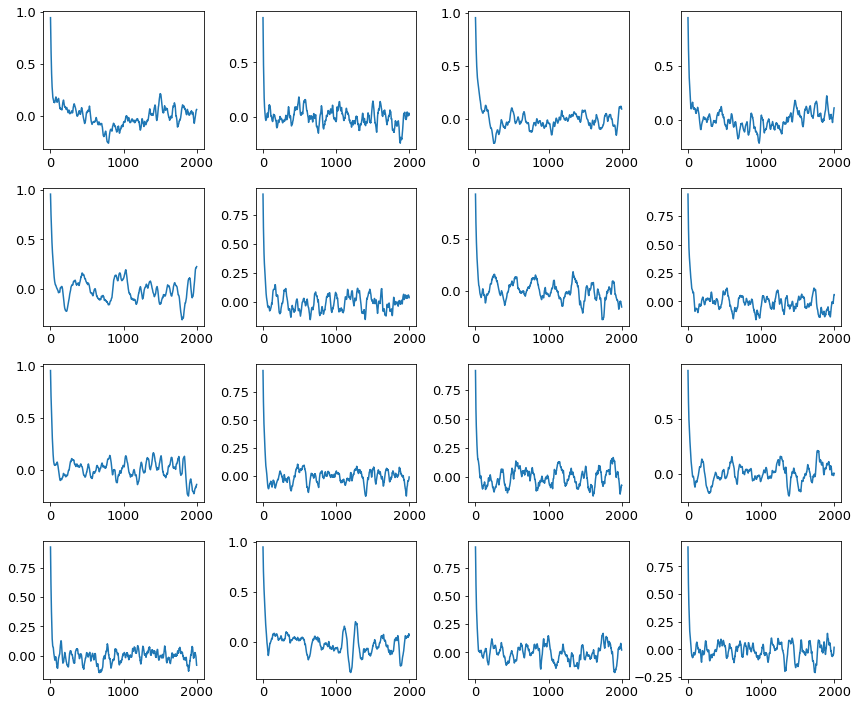

In [9]:
# plot auto-correlation

fig, axs = plt.subplots(4, 4, figsize=(12, 10))
axs = axs.flatten()
max_lag = 2000
for i in range(len(axs)):
    auto_cor = []
    mean = np.mean(parameters[:, i])
    var = np.var(parameters[:, i])
    for lag in range(1, max_lag):
        param = parameters[lag:, i]
        param_lagged = parameters[:-lag, i]
        auto_cor.append(np.mean((param - mean) * (param_lagged - mean)) / var)
    axs[i].plot(np.arange(1, max_lag), auto_cor)
plt.tight_layout()
plt.show()

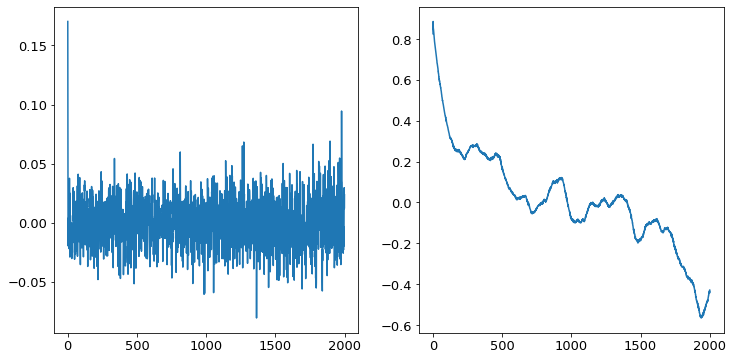

In [10]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
axs = axs.flatten()

mean = np.mean(log_gamma)
var = np.var(log_gamma)
auto_cor = []
for lag in range(1, max_lag):
    param = log_gamma[lag:]
    param_lagged = log_gamma[:-lag]
    auto_cor.append(np.mean((param - mean) * (param_lagged - mean)) / var)
axs[0].plot(np.arange(1, max_lag), auto_cor)

mean = np.mean(log_lambda)
var = np.var(log_lambda)
auto_cor = []
for lag in range(1, max_lag):
    param = log_lambda[lag:]
    param_lagged = log_lambda[:-lag]
    auto_cor.append(np.mean((param - mean) * (param_lagged - mean)) / var)
axs[1].plot(np.arange(1, max_lag), auto_cor)
plt.show()

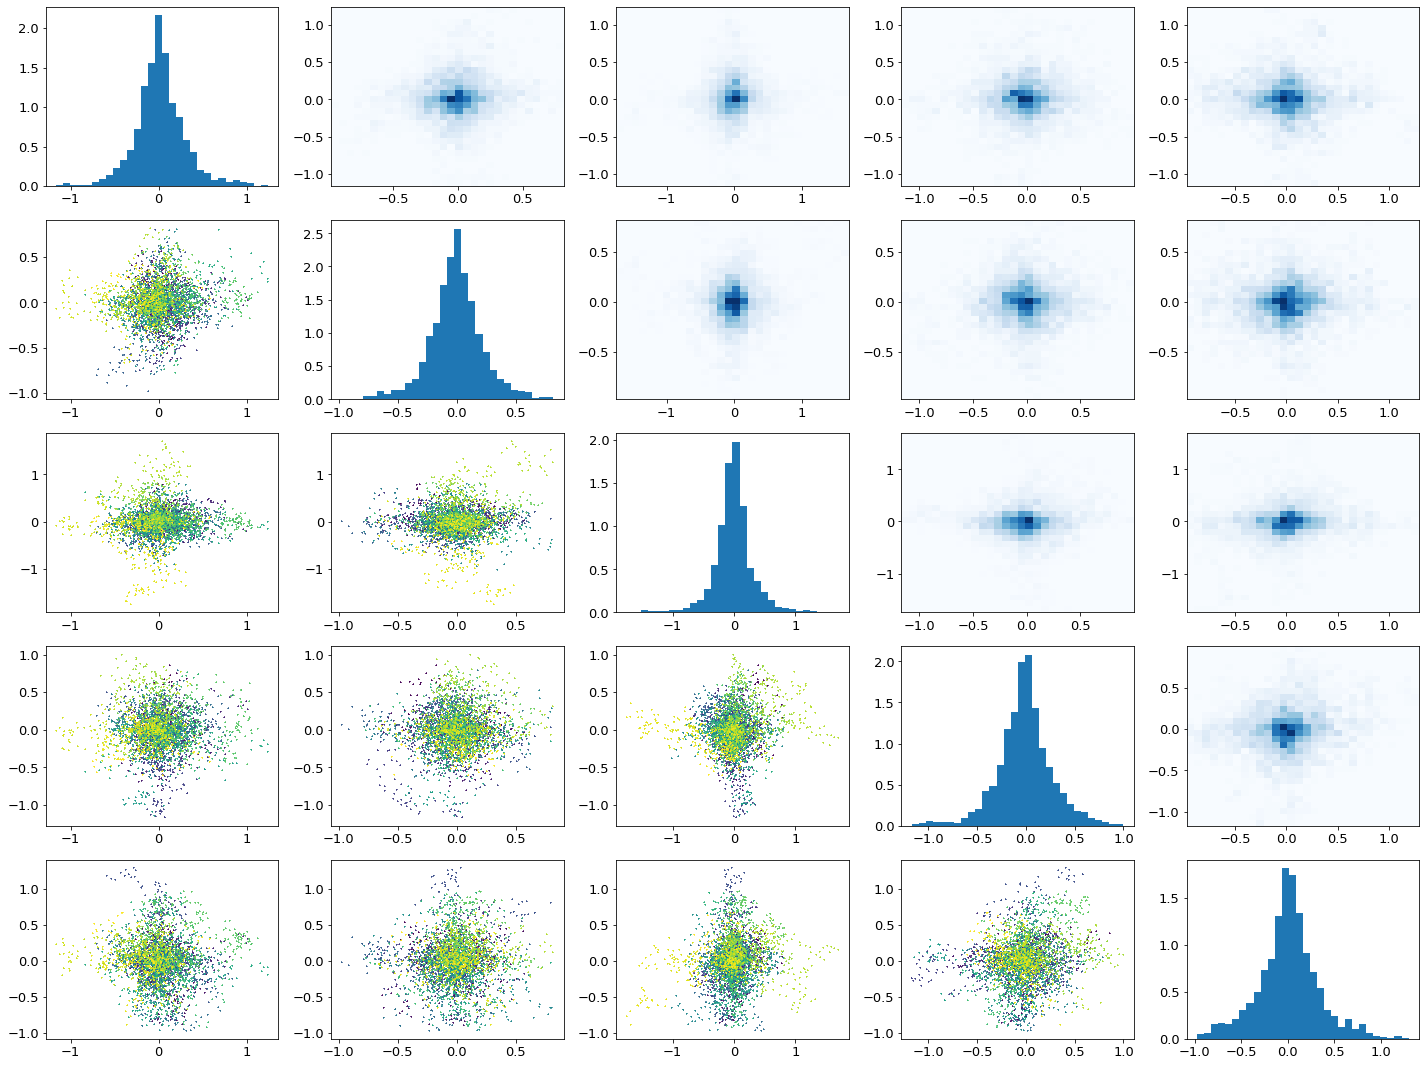

In [11]:
# plot parameters spread
fig, axs = plt.subplots(5, 5, figsize=(20, 15))
for i in range(axs.shape[0]):
    axs[i, i].hist(parameters[:, i], bins=30, density=True)
    for j in range(i):
        axs[i, j].scatter(parameters[:, j], parameters[:, i], s=1, marker="+", c=np.arange(parameters.shape[0]))
    for j in range(i + 1, axs.shape[0]):
        axs[i, j].hist2d(parameters[:, j], parameters[:, i], bins=30, cmap="Blues")
plt.tight_layout()
plt.show()

In [12]:
def diag_line(x,y,ax,SIF=False,color='black',xy=(.05,.76)):
    # remove NAN values in x, y series
    x,y = x.to_frame(), y.to_frame()
    x_y = pd.concat([x,y],axis=1)

    if x_y.isnull().values.any():
        x_y = x_y.dropna()

    x, y = x_y.iloc[:,0],x_y.iloc[:,1]

    max_value = max(max(x),max(y))
    min_value = min(min(x),min(y))
    mean_value= np.mean(x)


    line = np.linspace(min_value, max_value, 100)
    ax.plot(line, line,'--',color=color)
    slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
    RMSE = (((y - x) ** 2).mean()) ** .5

    ax.annotate(f'$N$ = {len(x)} \n$R^{2}$ = {np.around(r_value**2,decimals=3)} \n$RMSE$ = {np.around(RMSE,decimals=3)}',
                xy=xy, xycoords='axes fraction')

In [13]:
test['NEE_NN']  = NEE_testNN
test['Reco_NN'] = Reco_testNN
test['GPP_NN']  = GPP_testNN

train['NEE_NN']  = NEE_trainNN
train['Reco_NN'] = Reco_trainNN
train['GPP_NN']  = GPP_trainNN

test_sort  = test.sort_index()
train_sort = train.sort_index()

train_day   = train[train.APAR_label==1]
train_night = train[train.APAR_label==0]
test_day    = test[test.APAR_label==1]
test_night  = test[test.APAR_label==0]

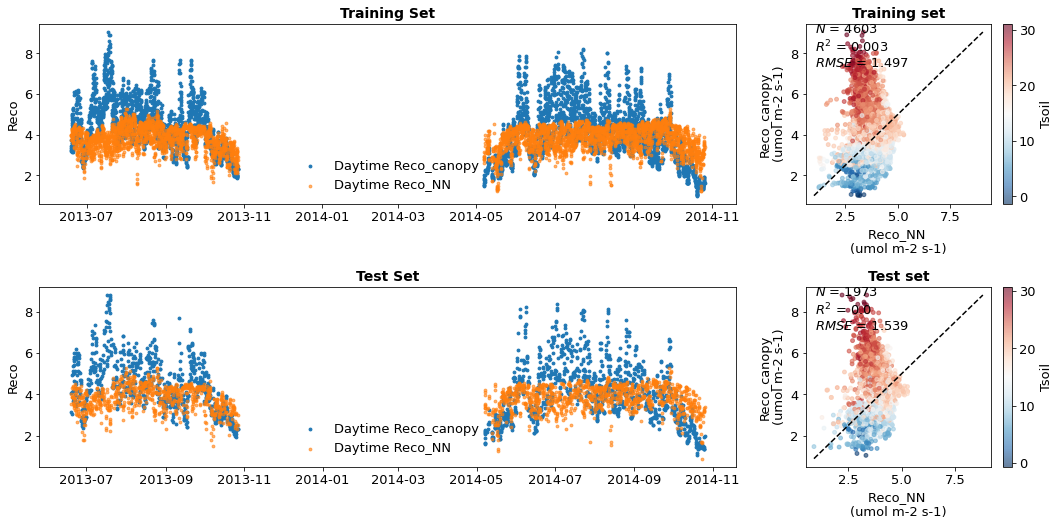

In [21]:
fig, ax = plt.subplots(figsize=(15,7.5),nrows=2,ncols=2,gridspec_kw={'width_ratios': [3, 1]})
s_circle = 8

colors = 'Tsoil'
cmap   = 'RdBu_r'
s      = 15
alpha  = 0.6
Reco_ref = 'Reco_canopy'


ax[0,0].scatter(train.index,train[Reco_ref], label='Daytime '+Reco_ref,s=s_circle)
ax[0,0].scatter(train.index,train['Reco_NN'], label='Daytime Reco_NN',s=s_circle,alpha=0.6)
ax[0,0].set_ylabel('Reco')
ax[0,0].set_title('Training Set', fontsize=14, fontweight='bold')


ax[1,0].scatter(test.index,test[Reco_ref], label='Daytime '+Reco_ref,s=s_circle)
ax[1,0].scatter(test.index,test['Reco_NN'], label='Daytime Reco_NN',s=s_circle,alpha=0.6)
ax[1,0].set_ylabel('Reco')
ax[1,0].set_title('Test Set', fontsize=14, fontweight='bold')


train.plot('Reco_NN',Reco_ref,alpha = alpha,ax=ax[0,1],kind='scatter',s=15,c=colors,cmap=cmap)
test.plot('Reco_NN',Reco_ref,alpha = alpha,ax=ax[1,1],kind='scatter',s=15,c=colors,cmap=cmap)

ax[0,1].set_xlabel('Reco_NN \n(umol m-2 s-1)')
ax[0,1].set_ylabel(''+Reco_ref+'\n(umol m-2 s-1)')
ax[1,1].set_xlabel('Reco_NN \n(umol m-2 s-1)')
ax[1,1].set_ylabel(''+Reco_ref+'\n(umol m-2 s-1)')


diag_line(train['Reco_NN'],  train[Reco_ref],ax=ax[0,1])
diag_line(test['Reco_NN'],  test[Reco_ref],ax=ax[1,1])


ax[0,1].set_title('Training set',fontsize=14,fontweight='bold')
ax[1,1].set_title('Test set',fontsize=14, fontweight='bold')


for each_ax in ax[:,0]:
    each_ax.legend(loc='best')

plt.tight_layout()
plt.rcParams['savefig.dpi'] = 220
T = dt.datetime.now().strftime("%Y%m%d-%H%M%S")
# plt.savefig('./FIGURE/NNSIF/SCOPE_Reco_'+str(i)+'.png')